# LV4
---

In [1]:
import tensorflow as tf
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')

            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e, "\n\n")

init_gpu()

1 Physical GPUs, 1 Logical GPUs




In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import math
import numpy as np
import tensorflow as tf
import keras
import h5py

from pathlib import Path

import matplotlib.pyplot as plt
import cv2
import math
from tqdm import tqdm

%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import albumentations as A

import seaborn
seaborn.set(style='white')
seaborn.set_context('paper')

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [4]:
BACKBONE = 'efficientnetb3'
CLASSES = ['building', 'road']

# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet')

model.load_weights('../Model/trained_model/E15/E15_4BnR.h5')
# E15_4

## Inference Functions
---

In [53]:
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    fig, axs = plt.subplots(1, n, figsize=(15, 8))
    
    for i, (name, image) in enumerate(images.items()):
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(' '.join(name.split('_')).title())
        axs[i].imshow(image)
        
    plt.tight_layout()
    plt.show()

In [41]:
def merge_img(sub_imgs, pts):
    merged = np.zeros((1024, 1024, 3))        # sub_imgs를 합친 이미지
    seg_map = np.zeros((1024, 1024))          # segmentation map, (0, 1, 2) 로 구성 ; (3, 1024, 1024)
    
    for i, (x0, x1, y0, y1) in enumerate(pts):
        sub_a = merged[x0:x1, y0:y1, :]        # [[0,0,0], [0,0,0], ...]
        sub_b = sub_imgs[i]
        added = np.where(sub_a > sub_b, sub_a, sub_b)
        reduced = np.argmax(added, axis=-1)   # 0, 1, 2 channel 중 큰 것
        merged[x0:x1, y0:y1, :] = added
        seg_map[x0:x1, y0:y1] = reduced
    
    return seg_map

In [42]:
def crop_png(img, pts):
    if len(img.shape) == 3:
        sub_imgs = [img[x0:x1, y0:y1, :] for x0, x1, y0, y1 in pts]
    elif len(img.shape) == 2:
        sub_imgs = [img[x0:x1, y0:y1] for x0, x1, y0, y1 in pts]
    return sub_imgs

In [43]:
def inference(model, img, pts):
    preprocessing = A.Compose([
        A.Lambda(image=sm.get_preprocessing(BACKBONE)),
    ])
    
    sub_imgs = crop_png(img, pts)
    sub_imgs = [preprocessing(image=img)['image'] for img in sub_imgs]
    sub_imgs = [np.expand_dims(img, axis=0) for img in sub_imgs]
    predict_imgs = [model.predict(img) for img in sub_imgs]
    predict_imgs = [predict.squeeze() for predict in predict_imgs]
    merged_img = merge_img(predict_imgs, pts)
    
    return merged_img

In [14]:
def coloring_seg_map(seg_map): # (1024, 1024) segmentation map -> (1024, 1024, 3)
    color_map = np.stack([seg_map, seg_map, seg_map], axis=-1)
    
    color_map = np.where(color_map == 0, COLOR_MAP[0], color_map)
    color_map = np.where(color_map == 1, COLOR_MAP[1], color_map)
    color_map = np.where(color_map == 2, COLOR_MAP[2], color_map).astype(np.uint8)
        
    return color_map

In [15]:
def show_inference(model, pts, img, gt):
    predicted = inference(model, img, pts)
    predicted = coloring_seg_map(predicted)
            
    visualize(
        image=img,
        ground_truth=gt,
        predicted=predicted
    )

In [17]:
 # ref : https://github.com/mapbox/robosat/blob/cbb1c73328183afd2d6351b7bfa3f430b73103ea/robosat/features/parking.py#L11
def denoise(mask, eps):
    struct = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (eps, eps))
    return cv2.morphologyEx(mask, cv2.MORPH_OPEN, struct)


def grow(mask, eps):
    struct = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (eps, eps))
    return cv2.morphologyEx(mask, cv2.MORPH_CLOSE, struct)


In [19]:
import random

def get_slice_pos(split_cnt, slice_type='sliding', stride_size=192, input_size=256, img_size=1024):
    pts = []
    
    if slice_type == 'sliding':
        n = math.sqrt(split_cnt)
        for slice_pos in range(split_cnt):
            pos_i = int(math.floor(slice_pos / n))
            pos_j = int(slice_pos % int(n))
            
            x = stride_size * pos_i
            y = stride_size * pos_j
            
            pts.append((x, x+input_size, y, y+input_size))
            
    elif slice_type =='crop':
        random.seed(2)
        get_random_point = lambda: random.randint(0, img_size-input_size)
        
        for _ in range(split_cnt):
            x = get_random_point()
            y = get_random_point()
            pts.append((x, x+input_size, y, y+input_size))
            
    return pts

## Sample Case
---

### Denoise

- constants 선언

In [39]:
COLOR_MAP = [
    (165, 42, 42),
    (0, 192, 0),
    (255,255,255)
]

pts = get_slice_pos(25)

In [26]:
FILE_PATH = '../Model/data/LV2_PNG_DATASET.h5'
BASE_TEST_DIR = "/val"
TEST_IMG_PATH = f'{Path(BASE_TEST_DIR)}/img'
TEST_LABEL_PATH = f'{Path(BASE_TEST_DIR)}/label'

- predict sample

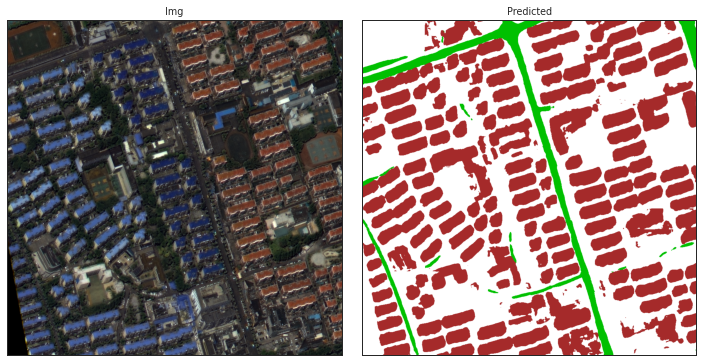

In [48]:
with h5py.File(FILE_PATH, "r") as f:
    idx = 0
    img = f[TEST_IMG_PATH][idx]
    gt = f[TEST_LABEL_PATH][idx]

predicted = coloring_seg_map(inference(model, img, pts))
visualize(img=img, predicted=predicted)

- denoise

In [57]:
kernel_size_denoise = 7
kernel_size_grow = 7
denoised = denoise(predicted, kernel_size_denoise)
grown = grow(denoised, kernel_size_grow)

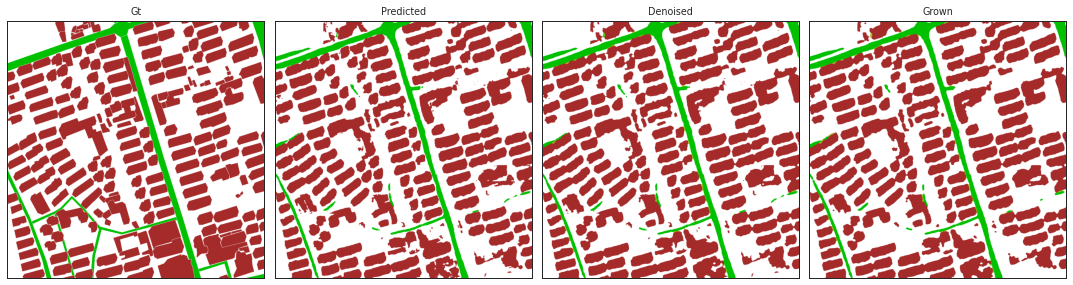

In [58]:
visualize(
    gt=gt,
    predicted=predicted,
    denoised=denoised,
    grown=grown
)

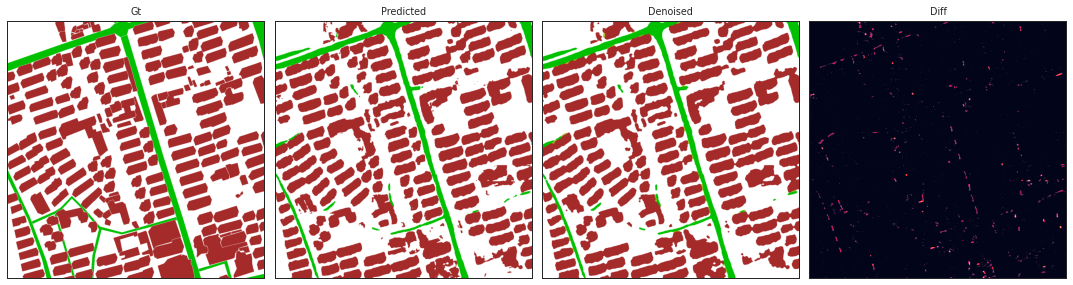

In [63]:
diff = np.sum(predicted-grown, axis=-1)

visualize(
    GT=gt,
    predicted=predicted,
    denoised=grown,
    diff=diff
)

### Contours

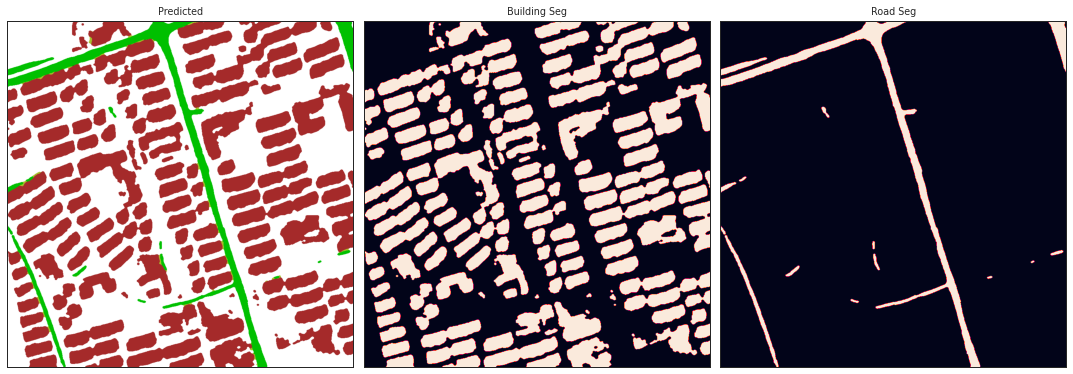

In [109]:
seg_maps = [(grown == v) for v in COLOR_MAP]
seg_maps = [(mask[:,:,0] * mask[:,:,1] * mask[:,:,2]) for mask in seg_maps]
visualize(
    predicted=grown,
    building_seg=seg_maps[0],
    road_seg=seg_maps[1]
)

138


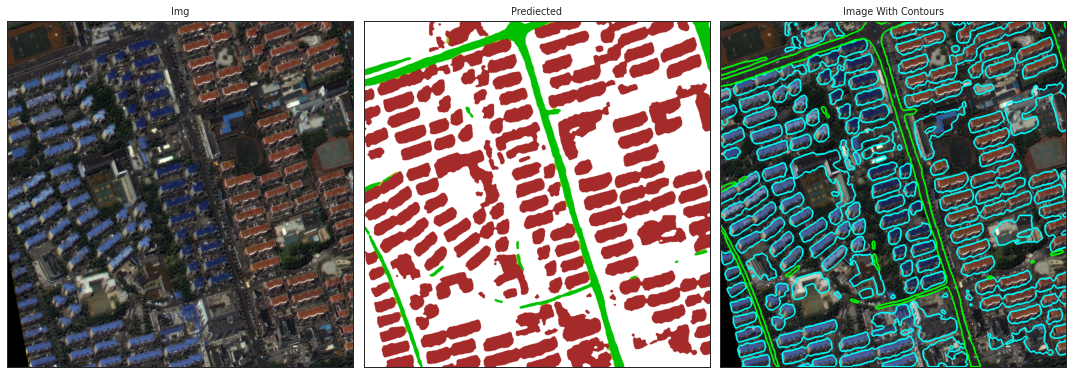

In [117]:
building_contours, hierachy  = cv2.findContours(seg_maps[0].astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
road_contours, hierachy  = cv2.findContours(seg_maps[1].astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

image_with_contours = cv2.drawContours(img.copy(), building_contours, -1, (0,255,255), 3)
image_with_contours = cv2.drawContours(image_with_contours, road_contours, -1, (0,255,0), 3)
print(len(contours) + len(road_contours))

visualize(
    img=img,
    prediected=grown,
    image_with_contours=image_with_contours
)

### contours to geojson

In [233]:
import xmltodict
import json
import re

from shapely.geometry import Polygon
from shapely import affinity

- parse kml

In [118]:
kml_path = '/home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/validation/raw/BLD01603_PS3_K3A_NIA0373.kml'

In [253]:
def parse_kml(kml_path):
    with open(kml_path) as f:
        lines = f.readlines()
        lines = [re.sub('[\n\t]', '', line) for line in lines]
        xml_str = "".join(lines)
        
    xml_dict = xmltodict.parse(xml_str)
    ground_overlay = xml_dict['kml']['Document']['Folder']['GroundOverlay']
    img_id = ground_overlay['Icon']['href']
    coordinates = ground_overlay['gx:LatLonQuad']['coordinates']
    coordinates = [coors.split(',')[:2] for coors in coordinates.split(' ')]
    coordinates = [[float(coors[0]), float(coors[1])] for coors in coordinates]
    coordinates.append(coordinates[0])
    
    return img_id, coordinates

In [254]:
img_id, coordinates = parse_kml(kml_path)
site_polygon = Polygon(coordinates)
print(img_id)
print(coordinates)
print(site_polygon.to_wkt())

BLD01603_PS3_K3A_NIA0373.PNG
[[121.5169202293, 31.2221623768], [121.5228314834, 31.2222304173], [121.5227524573, 31.2273104254], [121.5168408872, 31.2272423714], [121.5169202293, 31.2221623768]]
POLYGON ((121.5169202292999984 31.2221623768000001, 121.5228314833999974 31.2222304173000005, 121.5227524573000011 31.2273104253999989, 121.5168408872000043 31.2272423713999991, 121.5169202292999984 31.2221623768000001))


- contour_to_polygon

In [286]:
def contour_to_polygon(contours):
    pts = np.array([[point[0] for point in contour] for contour in contours ])
    polygons = [Polygon(p) for p in pts]
    return polygons

building_polygons = contour_to_polygon(building_contours)
road_polygons = contour_to_polygon(road_contours)

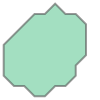

In [288]:
i = 10
building_polygons[i]

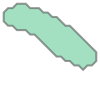

In [289]:
road_polygons[i]

- affine transform

In [257]:
def pix_coor_to_real_coor(site_geo, src, pix_size):
    real_URC = (site_geo.bounds[2], site_geo.bounds[3])
    real_LLC = (site_geo.bounds[0], site_geo.bounds[1])

    pix_width = pix_size # 1024*1024 고정
    pix_height = pix_size

    width_scale = abs((real_URC[0] - real_LLC[0]) / pix_width)
    height_scale = abs((real_URC[1] - real_LLC[1]) / pix_height)

    width_trans = real_LLC[0]
    height_trans = real_LLC[1]
        
    mirrored = affinity.affine_transform(src, [1, 0, 0, -1, 0, pix_height ])
    return affinity.affine_transform(mirrored, [width_scale, 0, 0, height_scale, width_trans, height_trans ])

In [290]:
building_real_coor_polygons = [pix_coor_to_real_coor(site_polygon, polygon, 1024) for polygon in building_polygons]
road_real_coor_polygons = [pix_coor_to_real_coor(site_polygon, polygon, 1024) for polygon in road_polygons]

- geopandas

In [291]:
import geopandas as gpd

data = {'type': ['building']*len(building_real_coor_polygons) + 
                ['road']*len(road_real_coor_polygons), 
        'geometry': building_real_coor_polygons + road_real_coor_polygons}
gdf = gpd.GeoDataFrame(data, crs="EPSG:4326")
gdf

,type,geometry
0,building,"POLYGON ((121.51877 31.22234, 121.51877 31.222..."
1,building,"POLYGON ((121.51764 31.22235, 121.51763 31.222..."
2,building,"POLYGON ((121.52017 31.22237, 121.52016 31.222..."
3,building,"POLYGON ((121.51754 31.22255, 121.51754 31.222..."
4,building,"POLYGON ((121.52282 31.22256, 121.52281 31.222..."
...,...,...
153,road,"POLYGON ((121.51727 31.22499, 121.51727 31.224..."
154,road,"POLYGON ((121.51861 31.22602, 121.51860 31.226..."
155,road,"POLYGON ((121.51760 31.22676, 121.51759 31.226..."
156,road,"POLYGON ((121.52250 31.22731, 121.52250 31.227..."


In [292]:
gdf.to_file('./test.geojson', driver="GeoJSON") 

In [293]:
gdf.head()

,type,geometry
0,building,"POLYGON ((121.51877 31.22234, 121.51877 31.222..."
1,building,"POLYGON ((121.51764 31.22235, 121.51763 31.222..."
2,building,"POLYGON ((121.52017 31.22237, 121.52016 31.222..."
3,building,"POLYGON ((121.51754 31.22255, 121.51754 31.222..."
4,building,"POLYGON ((121.52282 31.22256, 121.52281 31.222..."


In [294]:
gdf.tail()

,type,geometry
153,road,"POLYGON ((121.51727 31.22499, 121.51727 31.224..."
154,road,"POLYGON ((121.51861 31.22602, 121.51860 31.226..."
155,road,"POLYGON ((121.51760 31.22676, 121.51759 31.226..."
156,road,"POLYGON ((121.52250 31.22731, 121.52250 31.227..."
157,road,"POLYGON ((121.51935 31.22731, 121.51935 31.227..."
